 Importing data and libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import LSTM, SpatialDropout1D, Activation, GlobalAveragePooling1D, Dense, Input, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import ConfusionMatrixDisplay
import random

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [34]:
import keras
keras.__version__

'2.3.1'

In [35]:
# Load dataset
def load_data():
  data=pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
  data=data.drop('Unnamed: 0', axis=1)
  data=data.drop(labels=['hate_speech', 'offensive_language', 'neither', 'count'], axis=1)
  return data

In [36]:
label={0:'hate_speech', 1:'offensive_language', 2:'neither'}

In [37]:
# Plot data by target class
def plot(data):
  sns.countplot(data['class'])
  plt.xlabel('Class')
  plt.title('Distribution of data in each class')
  plt.ylabel('Count')
  plt.show()

 Cleaning tweets

In [38]:
# Data cleaning
def clean_text(data):
  for i in range(len(data)):
    txt = data.loc[i]["tweet"]
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt) #replace username-tags
    txt=re.sub(r'^[RT]+','',txt) #replace RT-tags
    txt = re.sub('https?://[A-Za-z0-9./]+','',txt) #replace URLs
    txt=re.sub("[^a-zA-Z]", " ",txt) #replace hashtags
    data.at[i,"tweet"]=txt
  return data

In [39]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/ethan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ethan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ethan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			# print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)
 

In [41]:
def random_deletion(words, p):

	#if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words




In [42]:
def random_swap(words, n):
  sent = ""
  new_words = words.copy()
  for _ in range(n):
    new_words = swap_word(new_words)
  return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words


In [43]:
def random_addition(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



In [44]:
# Splitting data into train-test with 15 as testset
def split_data(data):
  X=data['tweet']
  Y=data['class'].values
  Y=to_categorical(Y)
  X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.15)
  return X_train, y_train, X_test, y_test

In [45]:
# Data pre-processing
#token.word_index gives me the total vocabulary of the training data
#Creating vectorizer for LSTM
def create_token(X):
  token=Tokenizer() # Define Tokenizer
  token.fit_on_texts(X) # Train tokenizer
  word_index = token.word_index
  
  sequences=token.texts_to_sequences(X) # apply tokenizer on data
  pad_sequence=sequence.pad_sequences(sequences) # padding token sequernces to provide it as input
  #applying padding to ensure equal size of sequences.. length of padding matrix gives the size of input data
  return token, pad_sequence, word_index

# Creating LSTM model

In [57]:
def LSTM_model(max_words, max_phrase):
  model = Sequential()
  model.add(Embedding(input_dim = max_words, output_dim = 100, input_length = max_phrase))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(3, activation = 'softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  return model

In [58]:
def fit_model(model, pad_sequence, epochs=10, y_train = y_train):
  history = model.fit(pad_sequence, y_train, validation_split = 0.2, epochs = epochs, batch_size = 128)
  return model, history

In [59]:
def plot_model(hist):
  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.title('Accuracy')
  n = len(hist.history['accuracy'])
  plt.plot(np.arange(0, n), hist.history['accuracy'], label='Training accuracy')
  plt.plot(np.arange(0, n), hist.history['val_accuracy'], label='Val_accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Loss')
  plt.plot(np.arange(0, n), hist.history['loss'], label='Training loss')
  plt.plot(np.arange(0, n), hist.history['val_loss'],label='Val_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

Load dataset

In [60]:
data = load_data()
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


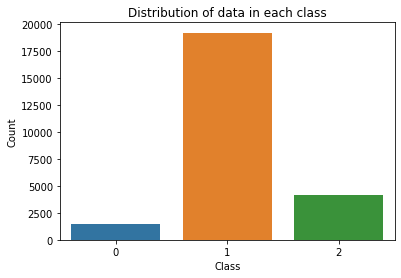

In [61]:
plot(data)

In [62]:
data = clean_text(data)
X_train, y_train, X_test, y_test = split_data(data)
print("Length of train data: {}".format(X_train.shape[0]))
print("Length of test data: {}".format(X_test.shape[0]))

Length of train data: 21065
Length of test data: 3718


In [63]:
token, train_pad, word_index = create_token(X_train)

In [64]:
data['tweet'][0]

'    RT  As a woman you shouldn t complain about cleaning up your house   amp  as a man you should always take the trash out   '

In [65]:
data_20 = data[:][:int(0.2*len(data))] # fixed 0.2 data for testing
data_80 = data[:][:int(-0.2*len(data))] # train model on 0.8 dataset

In [66]:
if len(data_20) + len(data_80) == len(data):
  print("Complete")

Complete


In [67]:
n = 9
data_sr = data_80.copy(deep=True)
for m,i in enumerate(data_80['tweet']):
  i = i.replace('  ', '')
  j = nltk.word_tokenize(i)
  data_sr['tweet'][m] = ' '.join(synonym_replacement(j, n))

data_sr.head()

,class,tweet
0,2,RTAs a fair sex you shouldn t sound off about ...
1,1,RTboy digital audiotape stale tyga dwn defecti...
2,1,RTDawg RTYou always roll in the hay a cunt and...
3,1,RT she flavour same a tranny
4,1,RTThe dickhead you get wind about me power be ...


In [68]:
p = 0.2
data_rd = data_80.copy(deep=True)
for i,tweet in enumerate(data_80['tweet']):
  tweet = tweet.replace('  ', '')
  j = nltk.word_tokenize(tweet)
  if len(j) < 2:
    continue
  data_rd['tweet'][i] = ' '.join(random_deletion(j, p))
data_rd.head()

,class,tweet
0,2,RTAs a woman you shouldn t complain about clea...
1,1,RTboy dats cold tyga dwn bad for cuffin dat ho...
2,1,RTDawg RTYou ever fuck a bitch and she be conf...
3,1,RT she like tranny
4,1,RTThe shit hear about me might true or it migh...


In [69]:
n = 9
data_rs = data_80.copy(deep=True)
for i, tweet in enumerate(data_80['tweet']):
  tweet = tweet.replace('  ', '')
  j = nltk.word_tokenize(tweet)
  if len(j) < 2:
    continue
  data_rs['tweet'][i] = ' '.join(random_swap(j, n))
data_rs.head()

,class,tweet
0,2,RTAs man cleaning a up house the about woman s...
1,1,RTboy cuffin in dats dat thest for place cold ...
2,1,RTDawg shit be as cryYou fuck RTYou she to sta...
3,1,RT look she like a tranny
4,1,RTThe shit to it true me you be be the it migh...


In [70]:
n = 9
data_ra = data_80.copy(deep=True)
for i, tweet in enumerate(data_80['tweet']):
  tweet = tweet.replace('  ', '')
  j = nltk.word_tokenize(tweet)
  if len(j) < 2:
    continue
  data_ra['tweet'][i] = ' '.join(random_addition(j, n))
data_ra.head()

,class,tweet
0,2,RTAs a woman you shouldn t complain about clea...
1,1,RTboy dats lay lay cold digital audiotape dwel...
2,1,ampere RTDawg RTYou ever eastern samoa fuck a ...
3,1,RT she feeling ampere the like the like look l...
4,1,RTThe shit you hear me about me might surgery ...


# Train LSTM model

In [75]:
lstm_model = LSTM_model(len(word_index)+1, train_pad.shape[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 34, 100)           1844600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 34, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 2,276,731
Trainable params: 2,276,731
Non-trainable params: 0
____________________________________________

In [76]:
lstm_model, lstm_hist = fit_model(lstm_model, train_pad, epochs=3) # Train LSTM model on train_pad (sentence tokens)

Train on 16852 samples, validate on 4213 samples
Epoch 1/3
16852/16852 [==============================] - 29s 2ms/step - loss: 0.6918 - accuracy: 0.7723 - val_loss: 0.6817 - val_accuracy: 0.7662
Epoch 2/3
16852/16852 [==============================] - 26s 2ms/step - loss: 0.6599 - accuracy: 0.7749 - val_loss: 0.6891 - val_accuracy: 0.7662
Epoch 3/3
16852/16852 [==============================] - 38s 2ms/step - loss: 0.6170 - accuracy: 0.7759 - val_loss: 0.7258 - val_accuracy: 0.7624


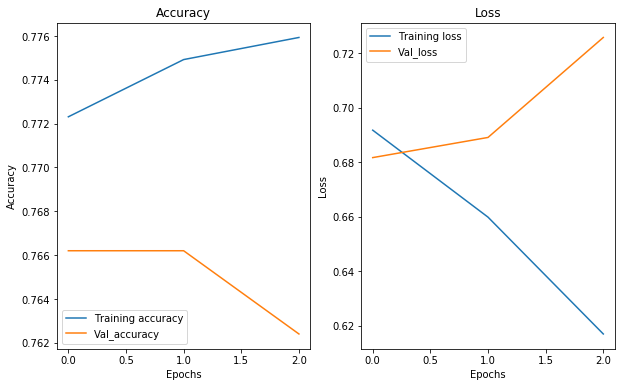

In [77]:
plot_model(lstm_hist)

In [78]:
def check_accuracy(model, X_test, y_test):
  test_sequences=token.texts_to_sequences(X_test)
  test_pad=sequence.pad_sequences(test_sequences, maxlen=train_pad.shape[1])
  y_pred = model.predict(test_pad)
  acc=model.evaluate(test_pad, y_test)
  print("Accuracy: {}".format(acc[1]))
  y_test_=np.argmax(y_test, axis=1)
  y_pred=np.argmax(y_pred, axis=1)
  print(metrics.classification_report(y_test_, y_pred))
  cm = confusion_matrix(y_test_, y_pred, normalize='true')
  
  np.set_printoptions(precision=2)
  # cm = confusion_matrix(y_test, y_pred)

  cm_display = ConfusionMatrixDisplay(cm, display_labels=label.values()).plot(cmap=plt.cm.Blues)

# Synonym replacement
Replace n words in the sentence with synonyms from wordnet

In [79]:
X_sr_train = data_sr['tweet']
y_sr_train = to_categorical(data_sr['class'].values)
X_sr_test = data_20['tweet']
y_sr_test = to_categorical(data_20['class'].values)

token, train_pad, word_index = create_token(X_sr_train)

In [80]:
lstm_sr_model = LSTM_model(len(word_index)+1, train_pad.shape[1])
lstm_sr_model, lstm_sr_hist = fit_model(lstm_sr_model, train_pad, y_train=y_sr_train, epochs=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 100)           3233900   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 3,666,031
Trainable params: 3,666,031
Non-trainable params: 0
____________________________________________

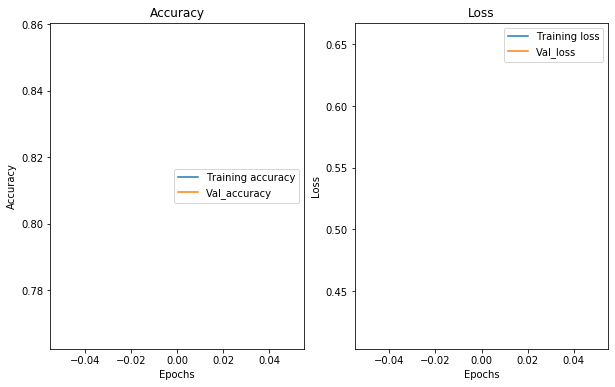

In [81]:
plot_model(lstm_sr_hist)

4956/4956 [==============================] - 3s 617us/step
Accuracy: 0.8042776584625244
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       386
           1       0.84      0.96      0.89      3731
           2       0.59      0.49      0.54       839

    accuracy                           0.80      4956
   macro avg       0.48      0.48      0.48      4956
weighted avg       0.73      0.80      0.76      4956



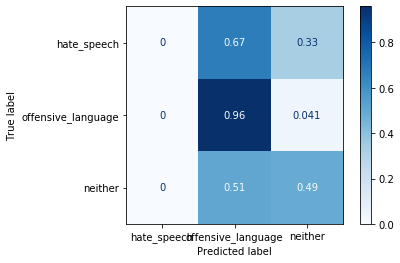

In [83]:
from sklearn import metrics
check_accuracy(lstm_sr_model, X_sr_test, y_sr_test)

# Random deletion
Randomly delete words from the sentence with probability p

In [84]:
X_rd_train = data_rd['tweet']
y_rd_train = to_categorical(data_sr['class'].values)
X_rd_test = data_20['tweet']
y_rd_test = to_categorical(data_20['class'].values)

token, train_pad, word_index = create_token(X_rd_train)

In [85]:
lstm_rd_model = LSTM_model(len(word_index)+1, train_pad.shape[1])
lstm_rd_model, lstm_rd_hist = fit_model(lstm_rd_model, train_pad, y_train=y_rd_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 100)           2455000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 28, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 2,887,131
Trainable params: 2,887,131
Non-trainable params: 0
____________________________________________

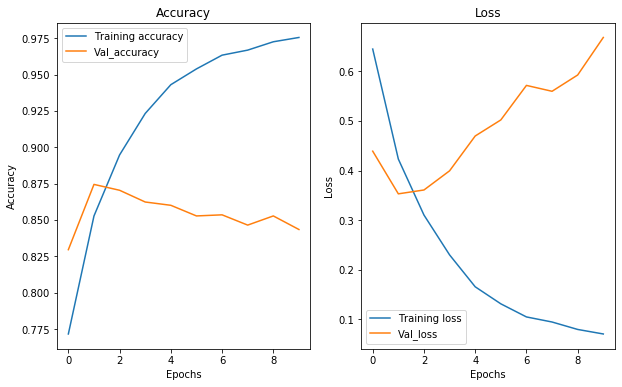

In [86]:
plot_model(lstm_rd_hist)

4956/4956 [==============================] - 2s 449us/step
Accuracy: 0.9402744174003601
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       386
           1       0.95      0.97      0.96      3731
           2       0.94      0.89      0.91       839

    accuracy                           0.94      4956
   macro avg       0.90      0.87      0.89      4956
weighted avg       0.94      0.94      0.94      4956



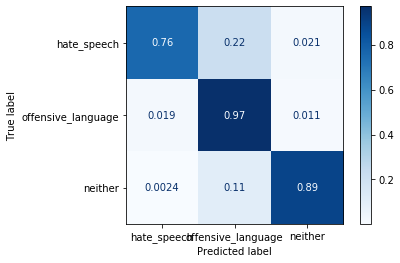

In [87]:
check_accuracy(lstm_rd_model, X_rd_test, y_rd_test)

# Random swap
Randomly swap two words in the sentence n times

In [88]:
X_rs_train = data_rd['tweet']
y_rs_train = to_categorical(data_sr['class'].values)
X_rs_test = data_20['tweet']
y_rs_test = to_categorical(data_20['class'].values)

token, train_pad, word_index = create_token(X_rs_train)

In [89]:
lstm_rs_model = LSTM_model(len(word_index)+1, train_pad.shape[1])
lstm_rs_model, lstm_rs_hist = fit_model(lstm_rs_model, train_pad, y_train=y_sr_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 100)           2455000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 28, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 771       
Total params: 2,887,131
Trainable params: 2,887,131
Non-trainable params: 0
____________________________________________

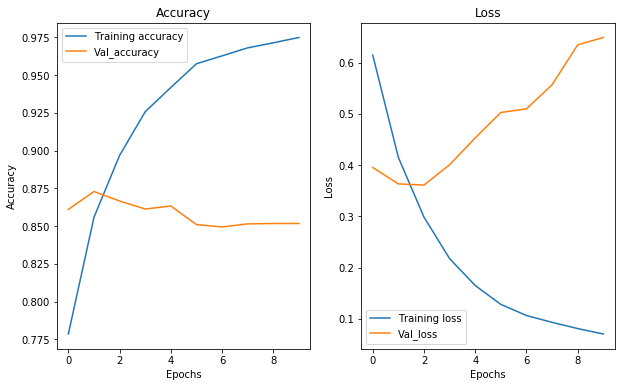

In [90]:
plot_model(lstm_rs_hist)

4956/4956 [==============================] - 2s 437us/step
Accuracy: 0.9439063668251038
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       386
           1       0.94      0.99      0.96      3731
           2       0.95      0.89      0.92       839

    accuracy                           0.94      4956
   macro avg       0.94      0.84      0.88      4956
weighted avg       0.94      0.94      0.94      4956



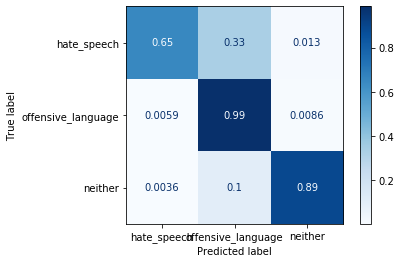

In [91]:
check_accuracy(lstm_rs_model, X_rs_test, y_rs_test)

# Random addition
Randomly add n words into the sentence


In [92]:
X_ra_train = data_rd['tweet']
y_ra_train = to_categorical(data_sr['class'].values)
X_ra_test = data_20['tweet']
y_ra_test = to_categorical(data_20['class'].values)

token, train_pad, word_index = create_token(X_ra_train)

In [93]:
lstm_ra_model = LSTM_model(len(word_index)+1, train_pad.shape[1])
lstm_ra_model, lstm_ra_hist = fit_model(lstm_ra_model, train_pad, y_train=y_ra_train)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 28, 100)           2455000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 28, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 2,887,131
Trainable params: 2,887,131
Non-trainable params: 0
____________________________________________

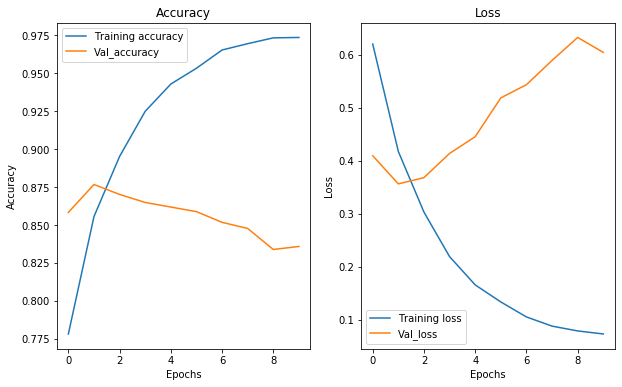

In [94]:
plot_model(lstm_ra_hist)

4956/4956 [==============================] - 2s 442us/step
Accuracy: 0.9390637874603271
              precision    recall  f1-score   support

           0       0.80      0.73      0.77       386
           1       0.95      0.97      0.96      3731
           2       0.94      0.89      0.91       839

    accuracy                           0.94      4956
   macro avg       0.90      0.86      0.88      4956
weighted avg       0.94      0.94      0.94      4956



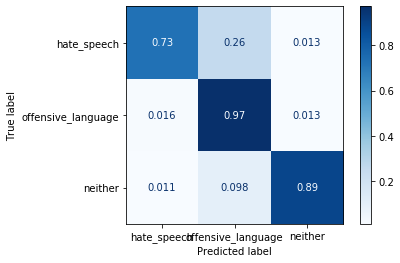

In [95]:
check_accuracy(lstm_ra_model, X_ra_test, y_ra_test)

# Compare accuracy

In [101]:

print("CNN accuracy : ")
check_accuracy(cnn_model, X_test, y_test)

CNN accuracy : 


ValueError: Error when checking input: expected embedding_1_input to have shape (34,) but got array with shape (28,)

In [1]:
from sklearn import metrics
print("LSTM accuracy : ")
check_accuracy(lstm_model, X_test, y_test)

LSTM accuracy : 


NameError: name 'check_accuracy' is not defined